## imports

In [37]:
import os
import sys
import faiss
import pretty_midi
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from numpy.linalg import norm
from scipy.stats import entropy
from itertools import combinations


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import basename
from src.utils.midi import transpose_midi, jitter
from src.ml.specdiff.model import SpectrogramDiffusion

## setup
### parameters

In [38]:
np.random.seed(0)

DATA_DIR = "/media/scratch/sageev-midi/20250420/augmented"
dataset = "/media/scratch/sageev-midi/20250420"
faiss_path = os.path.join(dataset, "specdiff.faiss")
# DATA_DIR = "/media/scratch/sageev-midi/teeny"
# temporary directory for transposed files
TMP_DIR = "/home/finlay/disklavier/tests/outputs/tmp"
os.makedirs(TMP_DIR, exist_ok=True)

In [39]:
model = SpectrogramDiffusion(fix_time=False, verbose=False)

04-26 13:49:40.677555 spcdif: initializing spectrogram diffusion model                                  ]8;id=886860;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=399880;file:///home/finlay/disklavier/src/ml/specdiff/model.py#53\53]8;;\

04-26 13:49:41.529176 spcdif: model initialization complete                                             ]8;id=487709;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=420862;file:///home/finlay/disklavier/src/ml/specdiff/model.py#80\80]8;;\

In [40]:
index = faiss.read_index(faiss_path)
print(f"FAISS index loaded. Contains {index.ntotal} vectors of dimension {index.d}.")

FAISS index loaded. Contains 959232 vectors of dimension 768.


In [41]:
# all_files = glob(os.path.join(DATA_DIR, "*.mid"))
# all_files.sort()
# base_files = glob(os.path.join(DATA_DIR, "*t00s00.mid"))
base_files = glob(os.path.join(DATA_DIR, "*.mid"))
base_files.sort()

# chosen_files = base_files
n_files = 2
n_rows = 2
n_cols = 2
# chosen_ids = np.random.choice(range(len(base_files)), size=n_files, replace=False)
chosen_files = list(np.random.choice(base_files, size=n_files, replace=False))

# [chosen_files.extend([base_files[id], base_files[id + 96]]) for id in chosen_ids]

all_results = []
chosen_files

['/media/scratch/sageev-midi/20250420/augmented/20231227-080-02_0132-0138_t02s07.mid',
 '/media/scratch/sageev-midi/20250420/augmented/20240402-064-04_0113-0120_t03s05.mid']

### selected files

first we'll transpose the first accompaniment file up

In [42]:
# transpose both files upwards 2 octaves
transposed_file = os.path.join(TMP_DIR, f"{basename(chosen_files[0])[:-7]}_t24s00.mid")
transpose_midi(chosen_files[0], transposed_file, 24)
print(
    f"transposed {basename(chosen_files[0])} up by 24 semitones to {basename(transposed_file)}"
)
chosen_files.insert(1, transposed_file)
transposed_file = os.path.join(TMP_DIR, f"{basename(chosen_files[-1])[:-7]}_t24s00.mid")
transpose_midi(chosen_files[-1], transposed_file, 24)
print(
    f"transposed {basename(chosen_files[-1])} up by 24 semitones to {basename(transposed_file)}"
)
chosen_files.append(transposed_file)
chosen_files

transposed 20231227-080-02_0132-0138_t02s07 up by 24 semitones to 20231227-080-02_0132-0138_t24s00
transposed 20240402-064-04_0113-0120_t03s05 up by 24 semitones to 20240402-064-04_0113-0120_t24s00


['/media/scratch/sageev-midi/20250420/augmented/20231227-080-02_0132-0138_t02s07.mid',
 '/home/finlay/disklavier/tests/outputs/tmp/20231227-080-02_0132-0138_t24s00.mid',
 '/media/scratch/sageev-midi/20250420/augmented/20240402-064-04_0113-0120_t03s05.mid',
 '/home/finlay/disklavier/tests/outputs/tmp/20240402-064-04_0113-0120_t24s00.mid']

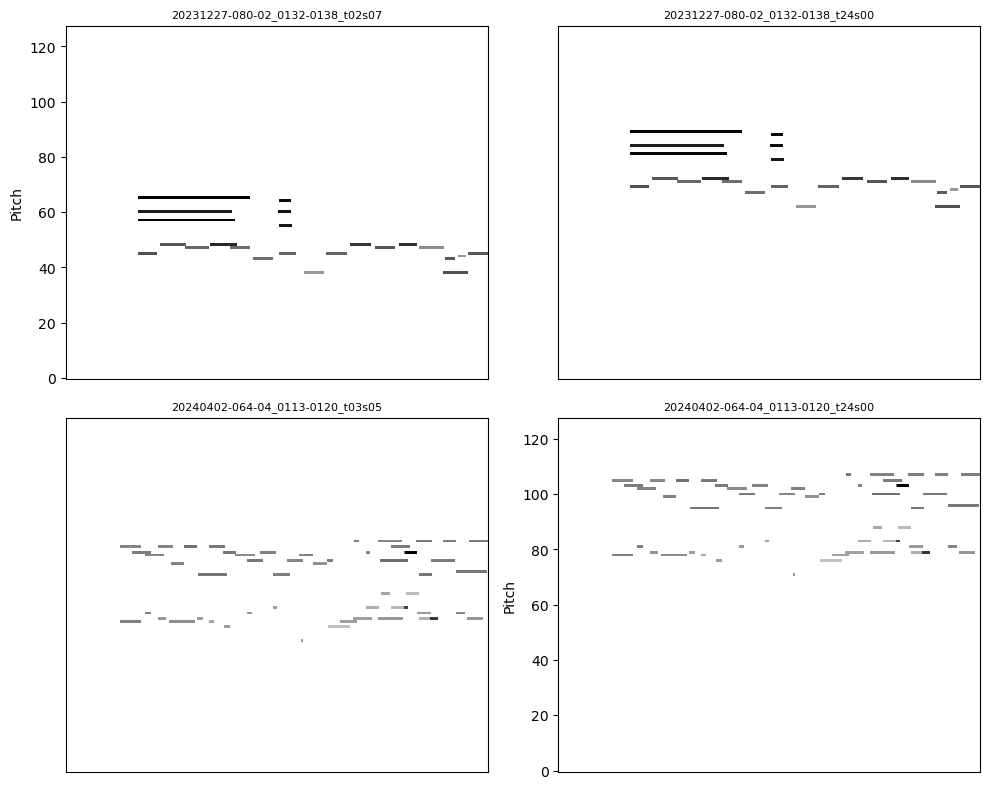

In [43]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, file_path in enumerate(chosen_files):

    midi_data = pretty_midi.PrettyMIDI(file_path)

    # Get piano roll (fs=100 means 100 samples per second)
    piano_roll = midi_data.get_piano_roll(fs=100)

    # Plot piano roll
    im = axes[i].imshow(
        piano_roll,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        interpolation="nearest",
    )

    # Set title to the filename (basename only)
    axes[i].set_title(basename(file_path), fontsize=8)

    # Set y-axis (pitch) labels for leftmost plots only
    if i % 3 == 0:
        axes[i].set_ylabel("Pitch")
    else:
        axes[i].set_yticks([])

    # Set x-axis (time) labels for bottom plots only
    if i >= 9:
        axes[i].set_xlabel("Time")
    else:
        axes[i].set_xticks([])

plt.tight_layout()
plt.show()

## helper functions

In [44]:
def get_pitch_histogram(midi_path, normalize=True, smooth=1e-6):
    """
    calculate the pitch histogram for a midi file over the full pitch range (0-127).

    parameters
    ----------
    midi_path : str
        path to the midi file.
    smooth : float
        smoothing factor added to all bins to avoid zeros.

    returns
    -------
    np.ndarray or none
        normalized pitch histogram (128 bins), or none if midi cannot be loaded.
    """
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    # Initialize histogram for pitches 0-127
    hist = np.zeros(128)
    for instrument in midi_data.instruments:
        if not instrument.is_drum:  # Optional: ignore drums
            for note in instrument.notes:
                # Ensure pitch is within valid range
                if 0 <= note.pitch <= 127:
                    if normalize:
                        hist[note.pitch] += (
                            note.end - note.start
                        )  # Use duration as weight
                    else:
                        hist[note.pitch] += 1

    if normalize:
        # Use total non-zero duration for normalization, or 1 if total duration is 0
        total_duration = hist.sum()
        # Add smoothing and normalize by duration
        hist += smooth * total_duration  # Scale smoothing by total duration
        hist /= hist.sum()

    return hist


def shift_histogram(hist, offset):
    """
    circularly shift a pitch histogram.

    parameters
    ----------
    hist : np.ndarray
        the pitch histogram (12 bins).
    offset : int
        the number of semitones to shift (positive or negative).

    returns
    -------
    np.ndarray
        the shifted histogram.
    """
    return np.roll(hist, offset)


def calculate_kl_divergence(p, q):
    """
    calculate kl divergence d_kl(p || q).

    parameters
    ----------
    p : np.ndarray
        first probability distribution.
    q : np.ndarray
        second probability distribution.

    returns
    -------
    float
        the kl divergence.
    """
    return entropy(p, q)


def plot_individual_difference(
    ax,
    df,
    title_prefix,
    offset=None,
    mag_label="Magnitude Diff",
    cos_label="Cosine Diff",
):
    """
    plot magnitude and cosine difference on primary and secondary y-axes using seaborn.

    parameters
    ----------
    ax : matplotlib.axes._axes.axes
        the axes to plot on.
    df : pd.dataframe
        dataframe containing 'transposition', 'magnitude difference', and 'cosine difference'.
    title_prefix : str
        prefix for the plot title.
    offset : int, optional
        transposition offset used for aligned plots. defaults to none.
    mag_label : str, optional
        label for the magnitude difference axis.
    cos_label : str, optional
        label for the cosine difference axis.
    """
    # Primary axis (Magnitude Difference)
    sns.lineplot(
        data=df,
        x="Transposition",
        y="Magnitude Difference",
        marker="o",
        label=mag_label,
        color="tab:blue",
        ax=ax,
    )
    ax.set_xlabel("Transposition (Semitones)")
    ax.set_ylabel(mag_label, color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")
    ax.grid(True, linestyle=":")

    # Secondary axis (Cosine Difference)
    ax2 = ax.twinx()
    sns.lineplot(
        data=df,
        x="Transposition",
        y="Cosine Difference",
        marker="s",
        linestyle="--",
        label=cos_label,
        color="tab:orange",
        ax=ax2,
    )
    ax2.set_ylabel(cos_label, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    ax2.set_ylim(0, 1)  # Set specific limits if needed for cosine diff

    # Title and Legend
    if offset is not None:
        ax.set_title(f"{title_prefix} (Aligned, Offset={offset})", fontsize=10)
        ax.set_xlabel("Original Transposition Label (Semitones)")
    else:
        ax.set_title(f"{title_prefix}", fontsize=10)

    # Combine legends from both axes
    # lines, labels = ax.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2, loc="best")
    ax.get_legend().remove()
    ax2.get_legend().remove()


def plot_heatmaps(embeddings_matrix, file_labels=None, transpose_labels=None):
    """
    generate heatmaps comparing embeddings between pairs of files across transpositions.

    parameters
    ----------
    embeddings_matrix : np.ndarray
        3d array of shape (n_files, n_transposes, len_embedding).
    file_labels : list[str], optional
        labels for the files (rows of the matrix).
    transpose_labels : list[str | int], optional
        labels for the transpositions (columns within each file).

    returns
    -------
    none
        displays the generated heatmaps.
    """
    n_files, n_transposes, _ = embeddings_matrix.shape

    if file_labels is None:
        file_labels = [f"file {i+1}" for i in range(n_files)]
    if transpose_labels is None:
        transpose_labels = list(range(n_transposes))

    # ensure labels match dimensions
    if len(file_labels) != n_files:
        raise ValueError(
            f"number of file labels ({len(file_labels)}) does not match number of files ({n_files})"
        )
    if len(transpose_labels) != n_transposes:
        raise ValueError(
            f"number of transpose labels ({len(transpose_labels)}) does not match number of transpositions ({n_transposes})"
        )

    for i, j in combinations(range(n_files), 2):
        file_i_embeddings = embeddings_matrix[i, :, :]
        file_j_embeddings = embeddings_matrix[j, :, :]

        magnitude_diff_matrix = np.zeros((n_transposes, n_transposes))
        cosine_sim_matrix = np.zeros((n_transposes, n_transposes))

        for t1 in range(n_transposes):
            for t2 in range(n_transposes):
                vec_i_t1 = file_i_embeddings[t1, :]
                vec_j_t2 = file_j_embeddings[t2, :]

                # magnitude difference
                magnitude_diff_matrix[t1, t2] = norm(vec_i_t1 - vec_j_t2)

                # cosine similarity
                norm_i_t1 = norm(vec_i_t1)
                norm_j_t2 = norm(vec_j_t2)
                if norm_i_t1 > 1e-9 and norm_j_t2 > 1e-9:  # check for non-zero vectors
                    cosine_sim = np.dot(vec_i_t1, vec_j_t2) / (norm_i_t1 * norm_j_t2)
                    # clip to handle potential floating point inaccuracies
                    cosine_sim_matrix[t1, t2] = np.clip(cosine_sim, -1.0, 1.0)
                else:
                    # assign 0 similarity if one or both vectors are zero
                    cosine_sim_matrix[t1, t2] = 0.0

        # plotting
        fig, axes = plt.subplots(
            1, 2, figsize=(16, 7)
        )  # increased figure size slightly

        # magnitude difference heatmap
        sns.heatmap(
            magnitude_diff_matrix,
            annot=True,
            fmt=".2f",
            cmap="viridis_r",  # reversed viridis: lower distance = brighter
            ax=axes[0],
            xticklabels=transpose_labels,
            yticklabels=transpose_labels,
            square=True,  # make cells square
            linewidths=0.5,  # add lines between cells
            cbar_kws={"shrink": 0.8},  # shrink color bar slightly
        )
        axes[0].set_title(f"magnitude difference")
        axes[0].set_xlabel(f"transpose index ({file_labels[j]})")
        axes[0].set_ylabel(f"transpose index ({file_labels[i]})")
        axes[0].tick_params(axis="x", rotation=45)
        axes[0].tick_params(axis="y", rotation=0)

        # cosine similarity heatmap
        sns.heatmap(
            cosine_sim_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",  # good for similarity (-1 to 1)
            ax=axes[1],
            vmin=-1,  # set range for cosine similarity
            vmax=1,
            xticklabels=transpose_labels,
            yticklabels=transpose_labels,
            square=True,  # make cells square
            linewidths=0.5,  # add lines between cells
            cbar_kws={"shrink": 0.8},  # shrink color bar slightly
        )
        axes[1].set_title(f"cosine similarity")
        axes[1].set_xlabel(f"transpose index ({file_labels[j]})")
        axes[1].set_ylabel(f"transpose index ({file_labels[i]})")
        axes[1].tick_params(axis="x", rotation=45)
        axes[1].tick_params(axis="y", rotation=0)

        title_suffix = f"{file_labels[i]} vs {file_labels[j]}"
        fig.suptitle(
            title_suffix,
            fontsize=16,
        )
        fig.tight_layout(
            rect=(0, 0.03, 1, 0.95)
        )  # adjust layout to prevent title overlap
        plt.show()

## embedding

In [45]:
embeddings = []
for file in chosen_files:
    embeddings.append(model.embed(file).squeeze().flatten())
embeddings = np.array(embeddings)
embeddings.shape

(4, 768)

### deltas

In [51]:
d1 = embeddings[3] - embeddings[1]
transpose_distance = embeddings[1] - embeddings[0]

print(f"Distance from d1 to target: {np.linalg.norm(d1 - embeddings[2])}")

adj_d1 = d1 - transpose_distance
print(f"Distance from adj_d1 to target: {np.linalg.norm(adj_d1 - embeddings[2])}")

Distance from d1 to target: 3.3371479511260986
Distance from adj_d1 to target: 5.2596211433410645


In [49]:
sims, indices = index.search(adj_d1[:, None], 5)
for s, i in zip(sims, indices):
    print(f"{base_files[i]}\t{s:.05f}")

AssertionError: 

## alignment

Reference file for alignment: 20231227-080-02_0132-0138_t02s07


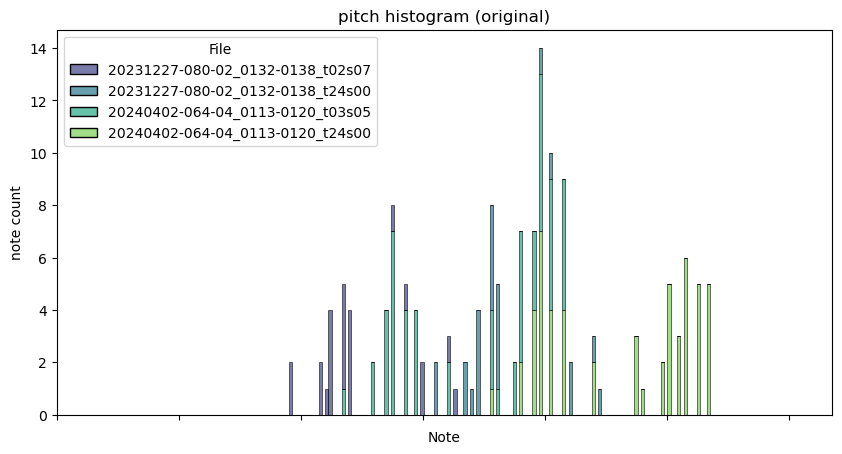

In [34]:
# --- Calculate Optimal Transpositions ---
optimal_offsets = {}
first_file = chosen_files[0]
print(f"Reference file for alignment: {basename(first_file)}")
hists = [get_pitch_histogram(f, normalize=False) for f in chosen_files]
hist_0 = get_pitch_histogram(first_file)

# Create a dataframe for the stacked histogram
hist_data = []
for i, hist in enumerate(hists):
    for note_idx, count in enumerate(hist):
        if count > 0:  # Only include non-zero values
            hist_data.append(
                {"Note": note_idx, "Count": count, "File": basename(chosen_files[i])}
            )

hist_df = pd.DataFrame(hist_data)
# Create a figure for stacked histogram
fig, ax_hist1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot stacked histogram using seaborn
sns.histplot(
    data=hist_df,
    x="Note",
    weights="Count",
    stat="count",
    hue="File",
    multiple="stack",
    palette="viridis",
    alpha=0.7,
    ax=ax_hist1,
    bins=128,
    legend=True,
)

ax_hist1.set_xlim(0, 127)
ax_hist1.set_xticklabels([])
ax_hist1.set_title("pitch histogram (original)")
ax_hist1.set_ylabel("note count")
fig.show()

here are all the segments as they are, without transposition, notes stacked

In [35]:
aligned_hists = []
for i, current_file in enumerate(chosen_files):
    hist_i = get_pitch_histogram(current_file)
    min_kl = float("inf")
    best_offset = 0
    possible_offsets = range(-24, 25)  # +/- 2 octaves

    for offset in possible_offsets:
        shifted_hist_i = shift_histogram(hist_i, offset)
        kl_div = calculate_kl_divergence(shifted_hist_i, hist_0)
        # print(f"  Offset {offset}: KL={kl_div:.4f}")
        if kl_div < min_kl:
            min_kl = kl_div
            best_offset = offset

    print(f"found optimal offset for '{basename(current_file)}': {best_offset}")
    aligned_hists.append(
        shift_histogram(get_pitch_histogram(current_file, normalize=False), best_offset)
    )
    optimal_offsets[current_file] = best_offset

found optimal offset for '20231227-080-02_0132-0138_t02s07': 0
found optimal offset for '20231227-080-02_0132-0138_t24s00': -24
found optimal offset for '20240402-064-04_0113-0120_t03s05': -11
found optimal offset for '20240402-064-04_0113-0120_t24s00': -14


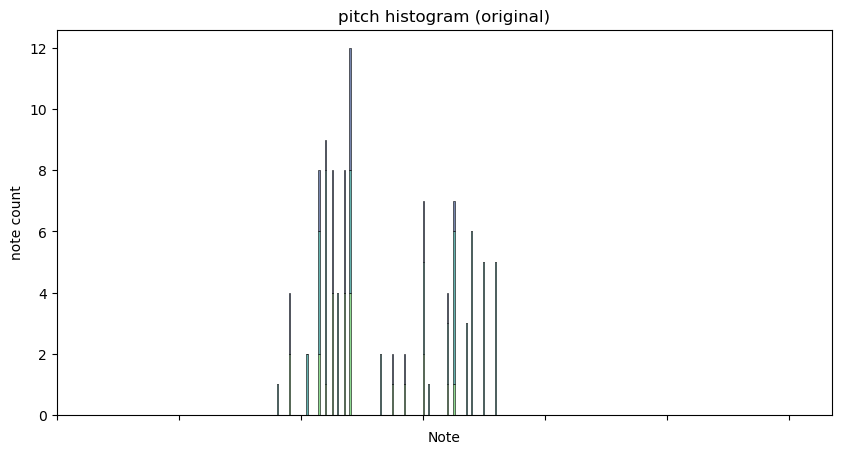

In [18]:
# Create a dataframe for the stacked histogram
hist_data = []
for i, hist in enumerate(aligned_hists):
    for note_idx, count in enumerate(hist):
        if count > 0:  # Only include non-zero values
            hist_data.append(
                {"Note": note_idx, "Count": count, "File": basename(chosen_files[i])}
            )

aligned_hist_df = pd.DataFrame(hist_data)
# Create a figure for stacked histogram
fig, ax_hist1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot stacked histogram using seaborn
sns.histplot(
    data=aligned_hist_df,
    x="Note",
    weights="Count",
    stat="count",
    hue="File",
    multiple="stack",
    palette="viridis",
    alpha=0.7,
    ax=ax_hist1,
    bins=128,
    legend=True,
)

ax_hist1.set_xlim(0, 127)
ax_hist1.set_xticklabels([])
ax_hist1.set_title("pitch histogram (original)")
ax_hist1.set_ylabel("note count")
fig.show()

### per file plots
Recalculate Embeddings and Differences using Aligned Base


Processing aligned base file: /media/scratch/sageev-midi/20250410/augmented/20231227-080-02_0132-0138_t02s07.mid
  Transposing 20231227-080-02_0132-0138_t02s07 by 0 semitones to 20231227-080-02_0132-0138_t02s07t00s00
  Results relative to base aligned by 0 semitones:
 Transposition  Magnitude Difference  Cosine Difference
             0              0.000000       5.960464e-08
             1              2.536871       5.234470e-01
             2              2.486422       5.104165e-01
             3              2.450969       4.860998e-01
             4              2.695071       6.171549e-01
             5              3.187354       7.220947e-01
             6              2.719798       6.133174e-01
             7              2.591120       5.422652e-01
             8              2.697284       6.119746e-01
             9              2.779282       6.401139e-01
            10              2.571423       5.635462e-01
            11              2.802383       6.522360e-01
    

IndexError: index 2 is out of bounds for axis 0 with size 2

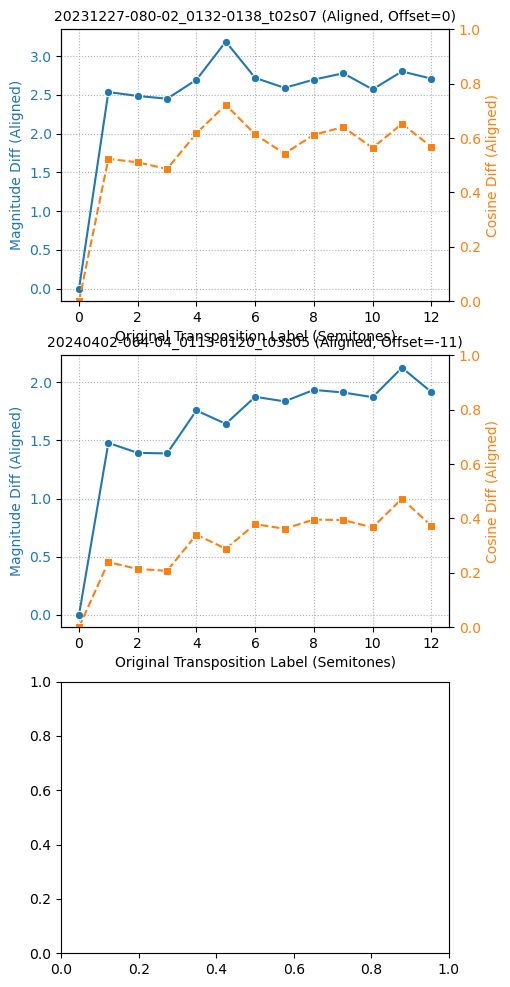

In [19]:
aligned_results = []
# Plotting setup for individual aligned files
fig_individual_aligned, axes_individual_aligned = plt.subplots(
    n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False
)
axes_individual_aligned = axes_individual_aligned.flatten()

aligned_diffs = np.zeros((n_files, 13, 768))
aligned_names = []

for i, base_file in enumerate(chosen_files):
    print(f"Processing aligned base file: {base_file}")
    base_name_prefix = basename(base_file)
    offset = optimal_offsets[base_file]
    offset_name = base_name_prefix + f"t{offset:02d}s00.mid"
    # offset_name = base_name_prefix.replace("t00s00", f"t{offset:02d}s00.mid")
    aligned_file_path = os.path.join(TMP_DIR, offset_name)
    aligned_names.append(basename(offset_name))
    # first transpose the file by the optimal offset
    try:
        print(
            f"  Transposing {base_name_prefix} by {offset} semitones to {basename(aligned_file_path)}"
        )
        transpose_midi(base_file, aligned_file_path, offset)
        aligned_base_embedding = model.embed(aligned_file_path).squeeze().flatten()
        aligned_base_embedding = aligned_base_embedding.flatten()
    except Exception as e:
        print(f"  Error processing aligned base {basename(aligned_file_path)}: {e}")
        continue
    aligned_diffs[i, 0, :] = np.zeros_like(aligned_base_embedding)

    # rename the transpositions based on offset
    transposed_files = [
        (
            os.path.join(TMP_DIR, base_name_prefix + f"t{offset + t:02d}.mid"),
            offset + t,
        )
        for t in range(13)
    ]
    results_aligned = []
    for j, (tmp_path, transposition) in enumerate(transposed_files):
        # print(f"    Generating embedding for transposition {transposition}: {basename(tmp_path)}")

        # Ensure we transpose the *original* t00 base file
        # print(f"transposing {base_file} by {transposition} to {tmp_path}")
        transpose_midi(base_file, tmp_path, transposition)
        transposed_embedding = model.embed(tmp_path).squeeze()

        # Calculate difference relative to the ALIGNED base embedding
        diff_vector = transposed_embedding - aligned_base_embedding
        aligned_diffs[i, j, :] = diff_vector
        magnitude_diff = norm(diff_vector)
        cosine_sim = np.dot(aligned_base_embedding, transposed_embedding) / (
            norm(aligned_base_embedding) * norm(transposed_embedding)
        )

        # Ensure cosine similarity is within [-1, 1]
        cosine_sim = np.clip(cosine_sim, -1.0, 1.0)
        cosine_diff = 1 - cosine_sim

        results_aligned.append(
            {
                "Transposition": transposition - offset,  # Original transposition label
                "Magnitude Difference": magnitude_diff,
                "Cosine Difference": cosine_diff,
                "File": base_name_prefix,
                "Aligned Base Offset": offset,  # Store the offset used for the base
            }
        )

    # Sort results by transposition for consistent table/plotting
    results_aligned.sort(key=lambda x: x["Transposition"])

    # Print table for the current aligned base file
    df_results_aligned = pd.DataFrame(results_aligned)
    print(f"  Results relative to base aligned by {offset} semitones:")
    print(
        df_results_aligned.to_string(
            index=False,
            columns=["Transposition", "Magnitude Difference", "Cosine Difference"],
        )
    )
    print("-" * 70)

    # Add base file info to results before extending the main list
    for res in results_aligned:
        res["BaseFile"] = base_name_prefix  # Original base file identifier

    # Store for aggregate plot
    aligned_results.extend(results_aligned)

    # Plotting for individual file (aligned)
    ax = axes_individual_aligned[i]
    plot_individual_difference(
        ax,
        df_results_aligned,
        base_name_prefix,
        offset=offset,
        mag_label="Magnitude Diff (Aligned)",
        cos_label="Cosine Diff (Aligned)",
    )

fig_individual_aligned.suptitle(
    "Embedding Differences vs. Transposition (Aligned Base Files)", fontsize=16
)
fig_individual_aligned.tight_layout(rect=(0, 0.03, 1, 0.97))
fig_individual_aligned.show()

each plot having the same filename in the title is a bug. but look at how well aligned they are now! we expect them to be identical from left to right, since they are the same file, but the top three files all exhibit similarspikes and drops at the same transpositions. neat. 

### aggregate plot

In [ ]:
df_all_aligned = pd.DataFrame(aligned_results)
fig_agg_aligned, ax_agg_aligned = plt.subplots(1, 2, figsize=(14, 6))

# Aggregate Magnitude Difference Plot (Aligned)
sns.lineplot(
    data=df_all_aligned,
    x="Transposition",
    y="Magnitude Difference",
    hue="BaseFile",  # Color by original base file group
    ax=ax_agg_aligned[0],
    alpha=0.5,
    marker="o",
    legend=False,
)
ax_agg_aligned[0].set_title("Aggregate Magnitude Difference (Aligned Base)")
ax_agg_aligned[0].set_xlabel("Original Transposition Label (Semitones)")
ax_agg_aligned[0].set_ylabel("Magnitude Difference (L2 Norm)")
ax_agg_aligned[0].grid(True, linestyle=":")

# Aggregate Cosine Difference Plot (Aligned)
sns.lineplot(
    data=df_all_aligned,
    x="Transposition",
    y="Cosine Difference",
    hue="BaseFile",  # Color by original base file group
    ax=ax_agg_aligned[1],
    alpha=0.5,
    marker="o",
    legend=False,
)
ax_agg_aligned[1].set_title("Aggregate Cosine Difference (Aligned Base)")
ax_agg_aligned[1].set_xlabel("Original Transposition Label (Semitones)")
ax_agg_aligned[1].set_ylim(0, 1)
ax_agg_aligned[1].set_ylabel("Cosine Difference")
ax_agg_aligned[1].grid(True, linestyle=":")

fig_agg_aligned.suptitle(
    "Aggregate Embedding Differences vs. Transposition (Aligned Base)",
    fontsize=16,
)
fig_agg_aligned.tight_layout(rect=(0, 0.03, 1, 0.95))
fig_agg_aligned.show()

### direct delta comparisons

In [ ]:
plot_heatmaps(aligned_diffs[:4], aligned_names[:4], list(range(13)))

alignment is way stronger. still not perfect, as we saw with the per-file plots, but much stronger.